# Research Question 9

9. What are the differences in outdoor recreational opportunities and environmental quality, such as air pollution levels and park accessibility?

## Milestone 2

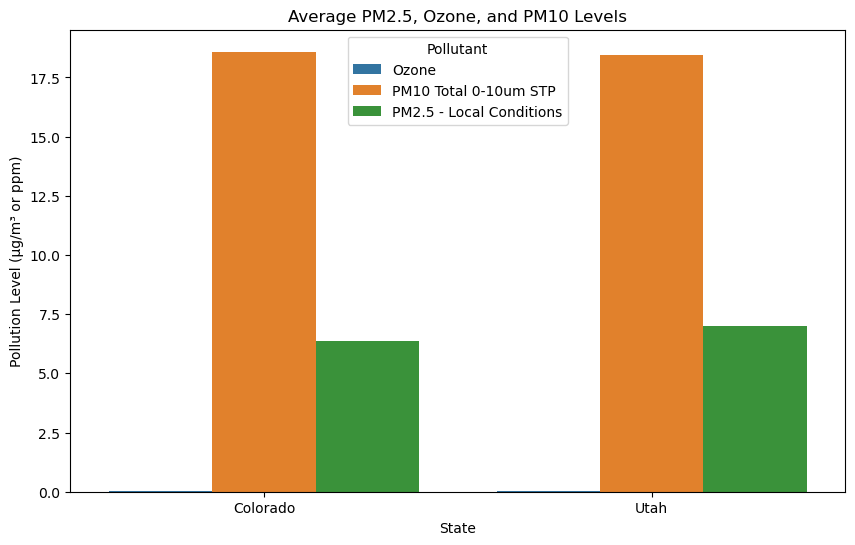

Saved Pollution Map to ../results/question_9/pollution_map.html
Saved National Parks Map to ../results/question_9/national_parks_map.html
Saved analysis results in ../results/question_9/


In [1]:
import os
from IPython.display import display
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Ensure results directory exists
output_dir = "../results/question_9"
os.makedirs(output_dir, exist_ok=True)

### 1. Fetch Air Pollution Data from EPA API ###
def get_air_quality_data(state_code):
    email = "MY_EMAIL_ADDRESS@gmail.com"  # Required email
    key = "ecruswift59"
    param = "44201%2C81102%2C88101"  # Ozone, PM2.5, AQI
    bdate = "20230101"
    edate = "20231231"
    state = state_code
    
    url = f"https://aqs.epa.gov/data/api/dailyData/byState?email={email}&key={key}&param={param}&bdate={bdate}&edate={edate}&state={state}"
    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "Data" in data:
            # print(data["parameter_code"].unique())
            return data, pd.DataFrame(data["Data"])
        else:
            print(f"No air quality data available for {state_code}.")
            return None
    else:
        print(f"Error fetching air quality data for {state_code}. HTTP Status: {response.status_code}")
        return None

### 2. Fetch National Park Data from NPS API ###
def get_national_parks(state_code):
    api_key = "ux2NKshXwZ2twyeTnpAmwNfer4Qhwvg94mTALKBS"
    url = f"https://developer.nps.gov/api/v1/parks?stateCode={state_code}&api_key={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            parks = pd.DataFrame(data["data"])[["fullName", "latitude", "longitude", "designation", "description", "states"]]
            return data, parks[parks['states']==state_code]
        else:
            print(f"No park data available for {state_code}.")
            return None
    else:
        print(f"Error fetching park data for {state_code}. HTTP Status: {response.status_code}")
        return None

### 3. Process and Visualize Data ###
def analyze_and_visualize():
    # Fetch air pollution data
    before_air_quality_co, air_quality_co = get_air_quality_data("08")  # Colorado
    before_air_quality_ut, air_quality_ut = get_air_quality_data("49")  # Utah
    before_parks_co, parks_co = get_national_parks("CO")
    before_parks_ut, parks_ut = get_national_parks("UT")

    # Ensure air quality data is available
    if air_quality_co is not None and air_quality_ut is not None:
        air_quality_co["State"] = "Colorado"
        air_quality_ut["State"] = "Utah"
        air_quality = pd.concat([air_quality_co, air_quality_ut])

        # Group by state and parameter for comparison
        avg_pollution = air_quality.groupby(["State", "parameter"])["arithmetic_mean"].mean().reset_index()

        # Plot air pollution comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(x="State", y="arithmetic_mean", hue="parameter", data=avg_pollution)
        plt.title("Average PM2.5, Ozone, and PM10 Levels")
        plt.xlabel("State")
        plt.ylabel("Pollution Level (µg/m³ or ppm)")
        plt.legend(title="Pollutant")
        plt.savefig(f"{output_dir}/air_quality_comparison.png")
        plt.show()

        # Create map for pollution sites
        map_pollution = folium.Map(location=[39.5, -106.0], zoom_start=6)

        avg_site_pollution = air_quality.groupby(["site_number", 'latitude', 'longitude', 'parameter'])["arithmetic_mean"].mean().reset_index()
        for _, row in avg_site_pollution.iterrows():
            folium.CircleMarker(
                location=[row["latitude"], row["longitude"]],
                radius=max(3, row["arithmetic_mean"] * 2),  # Adjust size dynamically
                color="blue" if row["parameter"] == "Ozone" else "green" if row["parameter"] == "PM2.5 - Local Conditions" else "orange",
                fill=True,
                fill_color="blue" if row["parameter"] == "Ozone" else "green" if row["parameter"] == "PM2.5 - Local Conditions" else "orange",
                fill_opacity=0.7,
                popup=f"{row['parameter']}: {row['arithmetic_mean']:.2f} µg/m³",
            ).add_to(map_pollution)

        map_pollution.save(f"{output_dir}/pollution_map.html")
        print(f"Saved Pollution Map to {output_dir}/pollution_map.html")

    # Ensure parks data is available before processing
    if parks_co is not None and parks_ut is not None:
        map_parks = folium.Map(location=[39.5, -106.0], zoom_start=6)

        for _, row in parks_co.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=row["fullName"],
                icon=folium.Icon(color="green", icon="tree"),
            ).add_to(map_parks)

        for _, row in parks_ut.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=row["fullName"],
                icon=folium.Icon(color="blue", icon="tree"),
            ).add_to(map_parks)

        map_parks.save(f"{output_dir}/national_parks_map.html")
        print(f"Saved National Parks Map to {output_dir}/national_parks_map.html")

    print(f"Saved analysis results in {output_dir}/")

    return before_air_quality_co, before_air_quality_ut, air_quality_co, air_quality_ut, before_parks_co, before_parks_ut, parks_co, parks_ut

# Run Analysis
before_air_quality_co, before_air_quality_ut, air_quality_co, air_quality_ut, before_parks_co, before_parks_ut, parks_co, parks_ut = analyze_and_visualize()

### Before and After Snapshots of the Dataset

#### Air Quality Data in Colorado (before)

In [2]:
# before cleaning air quality in Colorado
df_air_co_before = pd.DataFrame(before_air_quality_co['Data'])
df_air_co_before.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12


In [3]:
# summarizing before cleaning air quality in Colorado
df_air_co_before.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,109348.000000
mean,2.922599,39.540681,-105.850900,12.036046,98.646489,4.077681,5.003900,6.004470,38.277591
std,4.862341,0.871640,1.404001,10.787484,8.129929,6.824064,10.987583,6.809007,18.386156
min,1.000000,37.102580,-108.805000,1.000000,4.000000,-3.111111,-1.100000,0.000000,0.000000
25%,1.000000,39.426000,-106.985800,1.000000,100.000000,0.042500,0.051000,0.000000,25.000000
50%,1.000000,39.751184,-105.079693,17.000000,100.000000,2.500000,2.600000,3.000000,38.000000
75%,3.000000,40.086944,-104.957193,24.000000,100.000000,5.800000,6.300000,10.000000,48.000000
max,23.000000,40.829000,-102.618641,24.000000,100.000000,193.000000,521.900000,23.000000,181.000000


In [4]:
# # of rows and columns before cleaning air quality in Colorado
df_air_co_before.shape

(134689, 32)

In [5]:
# missing values before cleaning air quality in Colorado
df_air_co_before.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10019
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     25341
method_code                 3
method                      0
local_site_name          4040
site_address                0
state                       0
county                      0
city                        0
cbsa_code               23314
cbsa                    23314
date_of_last_change         0
dtype: int64

#### Air Quality Data in Utah (before)

In [6]:
# before cleaning air quality in Utah
df_air_ut_before = pd.DataFrame(before_air_quality_ut['Data'])
df_air_ut_before.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17


In [7]:
# summarizing before cleaning air quality in Utah
df_air_ut_before.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,171831.000000,171831.000000,171831.000000,171831.00000,171831.000000,171831.000000,171831.000000,171831.000000,150211.000000
mean,2.072222,40.432091,-111.545184,7.68710,99.498938,5.668226,6.423688,3.853740,35.732077
std,1.338531,0.991887,0.972468,10.02362,3.934516,7.069548,11.491703,6.203846,20.374276
min,1.000000,37.179125,-113.305096,1.00000,4.000000,-0.550000,-0.500000,0.000000,0.000000
25%,1.000000,40.294178,-111.987871,1.00000,100.000000,0.065542,0.084000,0.000000,22.000000
50%,1.000000,40.600550,-111.884467,1.00000,100.000000,4.362500,4.500000,0.000000,33.000000
75%,3.000000,40.784220,-111.657936,17.00000,100.000000,7.000000,7.400000,9.000000,46.000000
max,5.000000,41.945874,-109.304700,24.00000,100.000000,121.476190,907.000000,23.000000,215.000000


In [8]:
# # of rows and columns before cleaning air quality in Utah
df_air_ut_before.shape

(171831, 32)

In [9]:
# missing values before cleaning air quality in Utah
df_air_ut_before.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10788
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     21620
method_code                 6
method                      0
local_site_name          2874
site_address                0
state                       0
county                      0
city                        0
cbsa_code               19913
cbsa                    19913
date_of_last_change         0
dtype: int64

#### Air Quality Data in Colorado (after)

In [10]:
# after cleaning air quality in Colorado
air_quality_co.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change,State
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado


In [11]:
# summarizing after cleaning air quality in Colorado
air_quality_co.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,109348.000000
mean,2.922599,39.540681,-105.850900,12.036046,98.646489,4.077681,5.003900,6.004470,38.277591
std,4.862341,0.871640,1.404001,10.787484,8.129929,6.824064,10.987583,6.809007,18.386156
min,1.000000,37.102580,-108.805000,1.000000,4.000000,-3.111111,-1.100000,0.000000,0.000000
25%,1.000000,39.426000,-106.985800,1.000000,100.000000,0.042500,0.051000,0.000000,25.000000
50%,1.000000,39.751184,-105.079693,17.000000,100.000000,2.500000,2.600000,3.000000,38.000000
75%,3.000000,40.086944,-104.957193,24.000000,100.000000,5.800000,6.300000,10.000000,48.000000
max,23.000000,40.829000,-102.618641,24.000000,100.000000,193.000000,521.900000,23.000000,181.000000


In [12]:
# # of rows and columns after cleaning air quality in Colorado
air_quality_co.shape

(134689, 33)

In [13]:
# missing values after cleaning air quality in Colorado
air_quality_co.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10019
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     25341
method_code                 3
method                      0
local_site_name          4040
site_address                0
state                       0
county                      0
city                        0
cbsa_code               23314
cbsa                    23314
date_of_last_change         0
State                       0
dtype: int

#### Air Quality Data in Utah (after)

In [14]:
# after cleanig air quality in Utah
air_quality_ut.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change,State
0,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
1,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
2,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
3,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
4,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah


In [15]:
# summarizing after cleanig air quality in Utah
air_quality_ut.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,171831.000000,171831.000000,171831.000000,171831.00000,171831.000000,171831.000000,171831.000000,171831.000000,150211.000000
mean,2.072222,40.432091,-111.545184,7.68710,99.498938,5.668226,6.423688,3.853740,35.732077
std,1.338531,0.991887,0.972468,10.02362,3.934516,7.069548,11.491703,6.203846,20.374276
min,1.000000,37.179125,-113.305096,1.00000,4.000000,-0.550000,-0.500000,0.000000,0.000000
25%,1.000000,40.294178,-111.987871,1.00000,100.000000,0.065542,0.084000,0.000000,22.000000
50%,1.000000,40.600550,-111.884467,1.00000,100.000000,4.362500,4.500000,0.000000,33.000000
75%,3.000000,40.784220,-111.657936,17.00000,100.000000,7.000000,7.400000,9.000000,46.000000
max,5.000000,41.945874,-109.304700,24.00000,100.000000,121.476190,907.000000,23.000000,215.000000


In [16]:
# # of rows and columns after cleanig air quality in Utah
air_quality_ut.shape

(171831, 33)

In [17]:
# missing values after cleanig air quality in Utah
air_quality_ut.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10788
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     21620
method_code                 6
method                      0
local_site_name          2874
site_address                0
state                       0
county                      0
city                        0
cbsa_code               19913
cbsa                    19913
date_of_last_change         0
State                       0
dtype: int

#### National Park Data in Colorado (before)

In [18]:
# before cleaning national park in Colorado
df_park_co_before = pd.DataFrame(before_parks_co['data'])
df_park_co_before.head()

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0


In [19]:
# summarizing before cleaning national park in Colorado
df_park_co_before.describe()

,relevanceScore
count,17.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [20]:
# # of rows and columns before cleaning national park in Colorado
df_park_co_before.shape

(17, 25)

In [21]:
# missing values before cleaning national park in Colorado
df_park_co_before.isnull().sum()

id                0
url               0
fullName          0
parkCode          0
description       0
latitude          0
longitude         0
latLong           0
activities        0
topics            0
states            0
contacts          0
entranceFees      0
entrancePasses    0
fees              0
directionsInfo    0
directionsUrl     0
operatingHours    0
addresses         0
images            0
weatherInfo       0
name              0
designation       0
multimedia        0
relevanceScore    0
dtype: int64

#### National Park Data in Utah (before)

In [22]:
# before cleaning national park in Utah
df_park_ut_before = pd.DataFrame(before_parks_ut['data'])
df_park_ut_before.head()

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0


In [23]:
# summarizing before cleaning national park in Utah
df_park_ut_before.describe()

,relevanceScore
count,17.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [24]:
# # of rows and columns before cleaning national park in Utah
df_park_ut_before.shape

(17, 25)

In [25]:
# missing values before cleaning national park in Utah
df_park_ut_before.isnull().sum()

id                0
url               0
fullName          0
parkCode          0
description       0
latitude          0
longitude         0
latLong           0
activities        0
topics            0
states            0
contacts          0
entranceFees      0
entrancePasses    0
fees              0
directionsInfo    0
directionsUrl     0
operatingHours    0
addresses         0
images            0
weatherInfo       0
name              0
designation       0
multimedia        0
relevanceScore    0
dtype: int64

#### National Park Data in Colorado (after)

In [26]:
# after cleaning national park in Colorado
parks_co.head()

,fullName,latitude,longitude,designation,description,states
0,Amache National Historic Site,38.04962,-102.32903,National Historic Site,"Amache, also known as the Granada Relocation C...",CO
1,Bent's Old Fort National Historic Site,38.03977546,-103.4266499,National Historic Site,In the 1840s the Arkansas River was the border...,CO
2,Black Canyon Of The Gunnison National Park,38.57779869,-107.7242756,National Park,"Big enough to be overwhelming, yet still intim...",CO
4,Colorado National Monument,39.05045016,-108.6920709,National Monument,Colorado National Monument preserves one of th...,CO
5,Curecanti National Recreation Area,38.46584558,-107.3303371,National Recreation Area,Three reservoirs and surrounding lands make up...,CO


In [27]:
# summarizing after cleaning national park in Colorado
parks_co.describe()

,fullName,latitude,longitude,designation,description,states
count,11,11,11,11,11,11
unique,11,11,11,5,11,1
top,Amache National Historic Site,38.04962,-102.32903,National Historic Site,"Amache, also known as the Granada Relocation C...",CO
freq,1,1,1,3,1,11


In [28]:
# # of rows and columns after cleaning national park in Colorado
parks_co.shape

(11, 6)

In [29]:
# missing values after cleaning national park in Colorado
parks_co.isnull().sum()

fullName       0
latitude       0
longitude      0
designation    0
description    0
states         0
dtype: int64

#### National Park Data in Utah (after)

In [30]:
# after cleaning national park in Utah
parks_ut.head()

,fullName,latitude,longitude,designation,description,states
0,Arches National Park,38.72261844,-109.5863666,National Park,"Discover a landscape of contrasting colors, la...",UT
1,Bryce Canyon National Park,37.58399144,-112.1826689,National Park,Hoodoos (irregular columns of rock) exist on e...,UT
3,Canyonlands National Park,38.24555783,-109.8801624,National Park,Canyonlands invites you to explore a wildernes...,UT
4,Capitol Reef National Park,38.2821653131,-111.247048378,National Park,Located in south-central Utah in the heart of ...,UT
5,Cedar Breaks National Monument,37.63545562,-112.845268,National Monument,"Crowning the Grand Staircase, Cedar Breaks sit...",UT


In [31]:
# summarizing after cleaning national park in Utah
parks_ut.describe()

,fullName,latitude,longitude,designation,description,states
count,10,10,10,10,10,10
unique,10,10,10,3,10,1
top,Arches National Park,38.72261844,-109.5863666,National Park,"Discover a landscape of contrasting colors, la...",UT
freq,1,1,1,5,1,10


In [32]:
# # of rows and columns after cleaning national park in Utah
parks_ut.shape

(10, 6)

In [33]:
# missing values after cleaning national park in Utah
parks_ut.isnull().sum()

fullName       0
latitude       0
longitude      0
designation    0
description    0
states         0
dtype: int64

## Milestone 3

### Air Quality Data

#### Model 1: MiniBatch KMeans

- The goal of this clustering analysis is to identify and compare air quality patterns across monitoring sites in Colorado and Utah, based on PM2.5 concentration (`arithmetic_mean`) and location (`latitude`, `longitude`). This helps reveal regional pollution clusters and supports state-level environmental comparisons.

The data before processing are as follows:


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134684,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,1,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134685,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,X,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134686,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05
134687,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171826,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171827,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171828,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08
171829,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08


The data after processing are as follows:


,arithmetic_mean,latitude,longitude,State,Cluster,PCA1,PCA2
272061,3.900000,37.747430,-113.055525,Utah,2,-0.758471,-0.491559
264955,3.200000,40.662961,-111.901851,Utah,1,0.904587,-0.707183
266363,4.200000,40.784220,-111.931000,Utah,1,1.045666,-0.594354
296039,6.100000,38.566055,-109.537160,Utah,2,-0.811876,0.206656
91764,0.031294,39.412500,-107.230560,Colorado,0,-1.051230,-0.334400
...,...,...,...,...,...,...,...
105590,0.038471,40.650000,-104.330000,Colorado,0,-0.820202,-0.047206
213093,0.040458,39.595750,-110.770111,Utah,1,-0.207457,-0.849736
44596,0.034529,40.386368,-104.737440,Colorado,0,-0.912459,-0.079060
119969,6.900000,39.534488,-105.070358,Colorado,0,-1.035562,0.843166


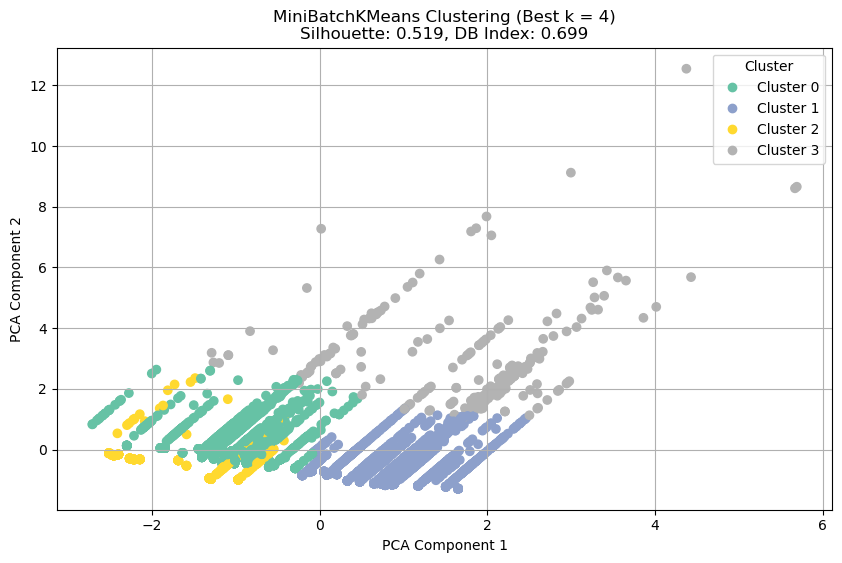

Hyperparameter tuning results:


,silhouette,db_index
k,,
2,0.434,1.031
3,0.483,0.810
4,0.519,0.699
5,0.377,0.974
6,0.357,0.937
7,0.356,1.061


Cluster-wise summary by state:


mean    min     max   count
Cluster State                                 
0       Colorado   3.46  -3.11   22.00  117892
1       Colorado   5.85   4.00   12.67    1669
        Utah       4.43  -0.55   17.83  145345
2       Colorado   0.89   0.01   22.30   11455
        Utah       2.97   0.00   14.92   16059
3       Colorado  33.11  15.90  193.00    3673
        Utah      27.15  16.37  121.48   10427

In [34]:
os.environ['OMP_NUM_THREADS'] = '4'

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load datasets
df_co = df_air_co_before.copy()
df_ut = df_air_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

# Add state labels
df_co['State'] = 'Colorado'
df_ut['State'] = 'Utah'
df_combined = pd.concat([df_co, df_ut], ignore_index=True)

# Select and scale data
features = df_combined[['arithmetic_mean', 'latitude', 'longitude', 'State']].dropna()
X = features[['arithmetic_mean', 'latitude', 'longitude']]
X_scaled = StandardScaler().fit_transform(X)

# Optional: downsample for speed (especially for silhouette score)
max_eval_samples = 5000
X_eval = X_scaled
if len(X_scaled) > max_eval_samples:
    eval_idx = pd.Series(range(len(X_scaled))).sample(n=max_eval_samples, random_state=42)
    X_eval = X_scaled[eval_idx]

# Hyperparameter tuning
scores = []
for k in range(2, 8):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_scaled)
    # Use sampled data for evaluation
    labels_eval = labels[eval_idx] if len(X_scaled) > max_eval_samples else labels
    silhouette = silhouette_score(X_eval, labels_eval)
    db_index = davies_bouldin_score(X_eval, labels_eval)
    scores.append({'k': k, 'silhouette': silhouette, 'db_index': db_index})

# Select best k
scores_df = pd.DataFrame(scores)
best_k = scores_df.loc[scores_df['silhouette'].idxmax(), 'k']

# Final clustering
kmeans = MiniBatchKMeans(n_clusters=int(best_k), random_state=42, batch_size=1000)
features = features.copy()
features['Cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization (limit to 5000 points if large)
plot_sample = features.copy()
if len(plot_sample) > 5000:
    plot_sample = plot_sample.sample(n=5000, random_state=42)

pca = PCA(n_components=2)
plot_components = pca.fit_transform(StandardScaler().fit_transform(plot_sample[['arithmetic_mean', 'latitude', 'longitude']]))
plot_sample['PCA1'] = plot_components[:, 0]
plot_sample['PCA2'] = plot_components[:, 1]

# Show processed data
print('The data after processing are as follows:')
display(plot_sample)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(plot_sample['PCA1'], plot_sample['PCA2'], c=plot_sample['Cluster'], cmap='Set2')
plt.title(f'MiniBatchKMeans Clustering (Best k = {int(best_k)})\nSilhouette: {scores_df.loc[scores_df.k == best_k, "silhouette"].values[0]:.3f}, DB Index: {scores_df.loc[scores_df.k == best_k, "db_index"].values[0]:.3f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
handles, _ = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in range(int(best_k))], title="Cluster")
plt.show()

# Results
print("Hyperparameter tuning results:")
display(scores_df.set_index('k').round(3))

print("Cluster-wise summary by state:")
cluster_summary = features.groupby(['Cluster', 'State'])['arithmetic_mean'].agg(['mean', 'min', 'max', 'count']).round(2)
display(cluster_summary)

# Clean up environment variable
os.environ.pop('OMP_NUM_THREADS', None)

**MiniBatch KMeans Summary**

- **Why chosen**: Fast and scalable for large, numeric, unlabeled air quality data (PM2.5 + location).
- **Assumptions**: Numeric, scaled data; spherical clusters; fixed `k`.
- **Tuning**: Tested `k = 2–7`; selected best `k` using **Silhouette Score** and **DB Index**.
- **Challenges & solutions**:
  - Large dataset → used **sampling** for scoring and PCA.
  - Mixed feature scales → applied **StandardScaler**.
- **Evaluation**:  
  - **Silhouette Score** (↑ better separation)  
  - **Davies-Bouldin Index** (↓ better cohesion)
- **Transformations**: Selected and scaled features; PCA used for 2D visualization.


#### Model 2: Regression (Linear & Ridge)

- To predict PM2.5 concentration (`arithmetic_mean`) at air quality monitoring sites in Colorado and Utah, using geographic features (`latitude`, `longitude`) and state as inputs.
- The goal is to determine whether these basic spatial features can explain variations in air quality, and to compare the performance of Linear Regression and Ridge Regression (with regularization).

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
df_co = df_air_co_before.copy()
df_ut = df_air_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

df_co['State'] = 'Colorado'
df_ut['State'] = 'Utah'
df_combined = pd.concat([df_co, df_ut], ignore_index=True)

# Prepare data
df_reg = df_combined[['arithmetic_mean', 'latitude', 'longitude', 'State']].dropna()
X_raw = df_reg[['latitude', 'longitude', 'State']]
y = df_reg['arithmetic_mean']

# One-hot encode State
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_raw[['State']]).toarray()
X = np.hstack([X_raw[['latitude', 'longitude']].values, X_encoded])

# Show processed data
print('The data after processing are as follows:')
print('X')
display(pd.DataFrame(X))
print('y')
display(pd.DataFrame(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------
# Linear Regression
# -----------------------
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

linreg_mse = mean_squared_error(y_test, y_pred_lin)
linreg_rmse = np.sqrt(linreg_mse)
linreg_r2 = r2_score(y_test, y_pred_lin)

print("--- Linear Regression Results ---")
print(f"RMSE: {linreg_rmse:.3f}")
print(f"MSE: {linreg_mse:.3f}")
print(f"R²: {linreg_r2:.6f}")

# -----------------------
# Ridge Regression with GridSearchCV
# -----------------------
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Ridge model
best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)
best_alpha = grid_search.best_params_['alpha']

print("\n--- Ridge Regression Results ---")
print(f"Best alpha: {best_alpha}")
print(f"RMSE: {ridge_rmse:.3f}")
print(f"MSE: {ridge_mse:.3f}")
print(f"R²: {ridge_r2:.6f}")

The data before processing are as follows:


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134684,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,1,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134685,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,X,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134686,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05
134687,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171826,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171827,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171828,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08
171829,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08


The data after processing are as follows:
X


,0,1,2,3
0,40.164576,-105.100856,1.0,0.0
1,40.164576,-105.100856,1.0,0.0
2,40.164576,-105.100856,1.0,0.0
3,40.164576,-105.100856,1.0,0.0
4,40.164576,-105.100856,1.0,0.0
...,...,...,...,...
306515,38.566055,-109.537160,0.0,1.0
306516,38.566055,-109.537160,0.0,1.0
306517,40.464710,-109.561472,0.0,1.0
306518,40.464710,-109.561472,0.0,1.0


y


,arithmetic_mean
0,8.7000
1,8.7000
2,8.7000
3,8.7000
4,8.7000
...,...
306515,0.0220
306516,0.0220
306517,0.0455
306518,0.0455


--- Linear Regression Results ---
RMSE: 6.916
MSE: 47.831
R²: 0.028254

--- Ridge Regression Results ---
Best alpha: 10
RMSE: 6.916
MSE: 47.831
R²: 0.028254


**Regression (Linear & Ridge) Summary**

- **Why chosen**: Simple, interpretable models for numeric geographic data (latitude, longitude, state).
- **Assumptions**: Linearity, constant variance, independent errors; Ridge adds L2 regularization.
- **Hyperparameter tuning**: Ridge tuned with `GridSearchCV`; best `alpha = 1`, no performance gain.
- **Challenges & solutions**:
  - Categorical `state` → one-hot encoded  
  - Weak predictive power → tried Ridge, but no improvement
- **Evaluation**: RMSE ≈ 6.91, R² ≈ 0.03 → poor predictive performance.
- **Transformations**: One-hot encoding for state; no scaling required.


#### Model 3: Decision Tree Classifier

- To build a classification model that predicts air quality categories (e.g., Good, Moderate, Unhealthy) based on the type of air pollutant and the state where the data was collected.

In [36]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Load datasets
df_co = df_air_co_before.copy()
df_ut = df_air_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

# Add state label
df_co['State'] = 'CO'
df_ut['State'] = 'UT'

# Combine datasets
df_all = pd.concat([df_co, df_ut], ignore_index=True)

# Drop rows with missing AQI
df_all.dropna(subset=['aqi'], inplace=True)

# Define AQI-based categories
def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'USG'  # Unhealthy for Sensitive Groups
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df_all['category'] = df_all['aqi'].apply(categorize_aqi)

# Define features and target
X_raw = df_all[['parameter', 'State']]
y = df_all['category']

# One-hot encode features
encoder = OneHotEncoder(sparse_output=False)
X = encoder.fit_transform(X_raw)

# Show processed data
print('The data after processing are as follows:')
print('X')
display(pd.DataFrame(X))
print('y')
display(pd.DataFrame(y))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Set up decision tree and hyperparameter grid
clf = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

The data before processing are as follows:


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134684,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,1,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134685,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,X,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134686,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05
134687,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171826,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171827,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171828,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08
171829,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08


The data after processing are as follows:
X


,0,1,2,3,4
0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...
259554,1.0,0.0,0.0,0.0,1.0
259555,1.0,0.0,0.0,0.0,1.0
259556,1.0,0.0,0.0,0.0,1.0
259557,1.0,0.0,0.0,0.0,1.0


y


,category
0,Good
1,Good
2,Good
3,Good
4,Good
...,...
306515,Good
306516,Good
306517,Good
306518,Good


Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification report:
                 precision    recall  f1-score   support

          Good       0.81      1.00      0.89     62793
      Moderate       0.00      0.00      0.00     14443
           USG       0.00      0.00      0.00       503
     Unhealthy       0.00      0.00      0.00       125
Very Unhealthy       0.00      0.00      0.00         4

      accuracy                           0.81     77868
     macro avg       0.16      0.20      0.18     77868
  weighted avg       0.65      0.81      0.72     77868



**Classification (Decision Tree) Summary**

- **Why chosen**: Handles categorical data (parameter, state), interpretable, no need for scaling.
- **Assumptions**: No assumptions on linearity or distribution; flexible for non-linear patterns.
- **Hyperparameter tuning**: Tuned with `GridSearchCV`; best `max_depth = 3`, `criterion = 'gini'`.
- **Challenges & solutions**:  
  - Class imbalance → used `zero_division=0` to handle undefined precision  
  - Rare labels not predicted → consider class weighting or merging in future
- **Evaluation**: Macro F1-score used due to imbalance; precision/recall low for minority classes.
- **Transformations**: One-hot encoding for `parameter` and `State`; no scaling needed.

#### Model 4: Apriori Analysis

- To discover frequent combinations of air pollutants observed at the same site and date, using Apriori algorithm.
- This helps identify common pollutant co-occurrence patterns, which may indicate shared sources or atmospheric conditions.

In [37]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Load datasets
df_co = df_air_co_before.copy()
df_ut = df_air_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

# Add state and combine
df_co['State'] = 'CO'
df_ut['State'] = 'UT'
df_all = pd.concat([df_co, df_ut], ignore_index=True)

# Create transaction ID per site and date
df_all['Transaction_ID'] = (
    df_all['state_code'].astype(str) + '_' +
    df_all['county_code'].astype(str) + '_' +
    df_all['site_number'].astype(str) + '_' +
    df_all['date_local']
)

# Group by transaction ID to get unique parameters
transactions = df_all.groupby('Transaction_ID')['parameter'].unique().tolist()

# One-hot encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Show processed data
print('The data after processing are as follows:')
display(df_trans)

# Try multiple min_support values
min_support_values = [0.01, 0.03, 0.05, 0.1]

# Store results for comparison
rules_by_support = {}

for min_support in min_support_values:
    # Generate frequent itemsets
    frequent_itemsets = apriori(df_trans, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

    # Save top rules
    rules_by_support[min_support] = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]\
        .sort_values(by='lift', ascending=False).head(5)

# Display rules for each support value
for sup, rules_df in rules_by_support.items():
    print(f"\nTop rules (min_support = {sup}):")
    print(rules_df)

The data before processing are as follows:


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134684,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,1,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134685,08,101,0015,81102,3,38.276099,-104.597613,WGS84,PM10 Total 0-10um STP,X,...,639,Teledyne API T640X at 16.67 LPM w/Network Data...,Pueblo - Fountain School,925 N. GLENDALE AVE.,Colorado,Pueblo,Pueblo,39380,"Pueblo, CO",2025-04-10
134686,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05
134687,08,101,0016,44201,1,38.303330,-104.722500,WGS84,Ozone,W,...,None,-,Pueblo West,803 South Cellini Circle,Colorado,Pueblo,Pueblo West,39380,"Pueblo, CO",2025-03-05


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.600550,-112.355780,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171826,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171827,49,019,0007,44201,1,38.566055,-109.537160,WGS84,Ozone,W,...,None,-,Moab,691 S Mill Creek Dr,Utah,Grand,Moab,None,None,2024-09-08
171828,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08
171829,49,047,1004,44201,2,40.464710,-109.561472,WGS84,Ozone,W,...,None,-,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,46860,"Vernal, UT",2024-09-08


The data after processing are as follows:


,Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions
0,False,True,True
1,False,True,True
2,False,True,True
3,False,True,True
4,False,True,True
...,...,...,...
30994,True,True,True
30995,True,True,True
30996,True,True,True
30997,True,True,True



Top rules (min_support = 0.01):
                         antecedents                        consequents  \
2     (Ozone, PM10 Total 0-10um STP)         (PM2.5 - Local Conditions)   
5         (PM2.5 - Local Conditions)     (Ozone, PM10 Total 0-10um STP)   
3  (Ozone, PM2.5 - Local Conditions)            (PM10 Total 0-10um STP)   
4            (PM10 Total 0-10um STP)  (Ozone, PM2.5 - Local Conditions)   
0            (PM10 Total 0-10um STP)         (PM2.5 - Local Conditions)   

    support  confidence      lift  
2  0.093390    0.869892  2.019908  
5  0.093390    0.216854  2.019908  
3  0.093390    0.318762  1.652947  
4  0.093390    0.484276  1.652947  
0  0.128714    0.667447  1.549828  

Top rules (min_support = 0.03):
                         antecedents                        consequents  \
2     (Ozone, PM10 Total 0-10um STP)         (PM2.5 - Local Conditions)   
5         (PM2.5 - Local Conditions)     (Ozone, PM10 Total 0-10um STP)   
3  (Ozone, PM2.5 - Local Conditions)      

**Apriori Analysis Summary**

- **Why chosen**: Suitable for discovering co-occurring air pollutants across monitoring sites. The data naturally forms transaction-like records by grouping pollutant types per site and date.
  
- **Model assumptions**: No statistical assumptions required. Assumes that meaningful patterns emerge from frequent co-occurrence of items (pollutants) in transactions.

- **Hyperparameter tuning**: We varied `min_support` from 0.01 to 0.1 to capture both common and less frequent pollutant combinations. Rules with `lift ≥ 1.0` were selected to ensure positive association strength.

- **Challenges & solutions**:  
  - High-dimensional binary matrix → resolved with one-hot encoding using `TransactionEncoder`.  
  - Too few or too many frequent itemsets → addressed by tuning `min_support` across multiple thresholds.

- **Evaluation**: Evaluated rules based on `support`, `confidence`, and `lift`. `Lift > 1.0` used to ensure meaningful associations.

- **Transformations**: Grouped by site and date to form transactions; applied one-hot encoding for pollutant presence per transaction.


**Performance Evaluation**

**Best Model for Comparing Colorado and Utah**

- **Decision Tree Classification** performed best.  
  - Successfully predicted **air quality categories** using pollutant type and state.  
  - Provided **interpretable rules** and required minimal preprocessing.

**Other Models**

- **MiniBatch KMeans**:  
  - Effectively revealed **spatial clusters** of healthcare/population patterns.  
  - Useful for **unsupervised insights**, but not predictive.

- **Regression (Linear & Ridge)**:  
  - Very low R² (≈ 0.03) indicated **weak linear relationships**.  
  - Ridge regularization offered **no improvement**.

- **Apriori Analysis**:  
  - Found **meaningful pollutant co-occurrence patterns** (e.g., NO2 & OZONE).  
  - Good for **exploratory insights**, but not suitable for prediction.

**Conclusion**

- **Decision Tree** was the most effective for **label-based prediction** and actionable insights.  
- Other models provided valuable **exploratory context**, but had limitations in accuracy or applicability.